# Demo: Frequency Response (Part 2)

This notebook makes use of interactive plots (i.e., plots that allow you to zoom in) that are enabled with the following command:
```python
%matplotlib widget
```

If you want to use interactive plots, you must have `ipympl` installed in your conda environment. If you have not already done so, you can install it by running the following command in a terminal (with the `ae353` environment active):
```zsh
conda install ipympl
```

#### Import modules and configure the notebook.

In [1]:
# These are standard modules
import time
import numpy as np
import sympy as sym
from scipy.signal import place_poles
from scipy import linalg
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_wheel_sensors

# Stupid hack because tornado is broken in jupyter
%matplotlib widget
# plt.ioff()
# plt.ion()

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Sep  3 2024 12:57:43


#### Choose parameter values

The equation of motion is

$$c_1 \ddot{q} = \tau - (c_2 \sin \phi) \sin q$$

where

* $q$ is the wheel angle
* $\tau$ is the wheel torque, i.e., the torque applied to the wheel by a motor on the ground
* $\phi$ is the "roll angle" of the ground with respect to horizontal

and where the values of $c_1$ and $c_2$ are given as follows:

In [2]:
# Values of c1 and c2 for the example (do not change)
c1 = 1.0
c2 = 2.0

# Values of other parameters that are given
g = 9.81 # <-- acceleration of gravity
r = 0.35 # <-- distance from wheel axis to marker (i.e., to the mass)

# Values of other parameters that correspond to the coefficients c1 and c2 that we chose
m = c2 / (g * r)   # <-- set in code
J = c1 - m * r**2  # <-- set in URDF
print(f'm = {m}\nJ = {J}')

m = 0.582495995340032
J = 0.928644240570846


#### Set up simulations

Create an instance of the `Simulator` class with particular values of `roll`, `mass`, and `inertia`.

In [3]:
simulator = ae353_wheel_sensors.Simulator(
    display=True,
    roll=0.,
    mass=m,
    inertia=J,
)

argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


#### Define functions to plot results

This function plots results in terms of nonlinear states and inputs.

In [4]:
def show_results(data, q_e, v_e, tau_e):
    t = data['t']
    q = data['wheel_angle']
    v = data['wheel_velocity']
    tau = data['wheel_torque']
    tau_cmd = data['wheel_torque_command']
    q_meas = data['wheel_angle_measurement']
    q_des = data['desired_wheel_angle']
    xhat = data['xhat']
    q_est = xhat[:, 0] + q_e
    v_est = xhat[:, 1] + v_e

    fig, (ax_q, ax_v, ax_tau) = plt.subplots(
        3, 1, figsize=(10, 8), sharex=True,
    )

    ax_q.plot(t, q, label=r'$q$', linewidth=4)
    ax_q.plot(t, q_est, '--', label=r'$q$ (estimated)', linewidth=4)
    ax_q.plot(t, q_meas, '.', markersize=1, label=r'$q$ (measured)')
    ax_q.plot(t, q_des, ':', label=r'$q$ (desired)')
    ax_q.plot(t, q_e * np.ones_like(t), ':', label=r'$q_e$', linewidth=3, color='C3')
    ax_v.plot(t, v, label=r'$v$', linewidth=4)
    ax_v.plot(t, v_est, '--', label=r'$v$ (estimated)', linewidth=4)
    ax_v.plot(t, v_e * np.ones_like(t), ':', label=r'$v_e$', linewidth=3, color='C3')
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
    ax_tau.plot(t, tau_cmd, '-.', label=r'$\tau$ (command)', linewidth=3, color='C6')
    tau_max = np.ones_like(t) * simulator.tau_max
    ax_tau.plot(t, tau_max,
                '--', label=r'$\tau$ (max)', linewidth=2, color='C2', zorder=0)
    ax_tau.plot(t, - tau_max,
                '--', linewidth=2, color='C2', zorder=0)

    ax_q.grid()
    ax_q.legend(fontsize=14, ncol=4, loc='upper right')
    ax_q.tick_params(labelsize=14)
    ax_q.set_ylim(np.min(q_des) - 0.5, np.max(q_des) + 0.5)

    ax_v.grid()
    ax_v.legend(fontsize=14, ncol=3, loc='upper right')
    ax_v.tick_params(labelsize=14)
    ax_v.set_ylim(v_e - 1., v_e + 1.)

    ax_tau.grid()
    ax_tau.legend(fontsize=14, ncol=3, loc='upper right')
    ax_tau.tick_params(labelsize=14)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

    ax_tau.set_xlabel('time (s)', fontsize=14)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])

    fig.tight_layout()
    plt.show()

This function plots only $q$ and $q_\text{des}$.

In [5]:
def show_results_q(data, q_e, v_e, tau_e, omega=None, mag=None, ang=None, linewidth=4):
    t = data['t']
    q = data['wheel_angle']
    q_des = data['desired_wheel_angle']
    q_est = data['xhat'][:, 0] + q_e
    if mag is not None:
        q_pre = mag * np.sin(omega * data['t'] + ang)
    fig, ax_q = plt.subplots(
        1, 1, figsize=(8, 4), sharex=True,
    )

    ax_q.plot(t, q, label=r'$q$', linewidth=linewidth, color='C0')
    ax_q.plot(t, q_des, '--', label=r'$q$ (desired)', linewidth=linewidth, color='C1')
    ax_q.plot(t, q_est, '-.', label=r'$q$ (estimated)', linewidth=linewidth-2, color='C2')
    if mag is not None:
        ax_q.plot(t, q_pre, ':', label=r'$q$ (predicted)', linewidth=linewidth-1, color='C6')
    ax_q.grid()
    ax_q.legend(fontsize=14, ncol=4, loc='upper right')
    ax_q.tick_params(labelsize=14)
    ax_q.set_ylim(-0.2, 0.2)
    ax_q.set_xlabel('time (s)', fontsize=14)
    ax_q.set_xlim([data['t'][0], data['t'][-1]])

    fig.tight_layout()
    plt.show()

#### Define functions to print numerical results nicely

In [6]:
def show_matrix(key, val):
    latex = sym.latex(sym.nsimplify(sym.Matrix(val), rational=True))
    display(Markdown(f'$${key} = {latex}$$'))
    
def show_transfer_function(key, val):
    latex = sym.latex(sym.nsimplify(val, rational=True))
    display(Markdown(f'$${key}(s) = {latex}$$'))

#### Do controller design

Derive state-space model.

In [7]:
# Define symbolic variables
q, v, tau = sym.symbols('q, v, tau')

# Define ODEs
f = sym.Matrix([
    v,
    tau / c1,
])

# Convert floats to rationals
f = sym.nsimplify(f, rational=True)

# Choose equilibrium point
(q_e, v_e, tau_e) = (0., 0., 0.)

# Linearize
A_num = sym.lambdify([q, v, tau], f.jacobian([q, v]))
A = A_num(q_e, v_e, tau_e).astype(float)
B_num = sym.lambdify([q, v, tau], f.jacobian([tau]))
B = B_num(q_e, v_e, tau_e).astype(float)

# Show result
show_matrix('A', A)
show_matrix('B', B)

$$A = \left[\begin{matrix}0 & 1\\0 & 0\end{matrix}\right]$$

$$B = \left[\begin{matrix}0\\1\end{matrix}\right]$$

Design controller by eigenvalue placement.

In [8]:
K = signal.place_poles(A, B, [-1. + 4. * 1j, -1. - 4. * 1j]).gain_matrix
show_matrix('K', K)

$$K = \left[\begin{matrix}17 & 2\end{matrix}\right]$$

#### Do observer design

Derive state-space model.

In [9]:
# Define nonlinear model
g = sym.Matrix([q])

# Convert floats to rationals
g = sym.nsimplify(g, rational=True)

# Linearize
C_num = sym.lambdify([q, v, tau], g.jacobian([q, v]))
C = C_num(q_e, v_e, tau_e).astype(float)
D_num = sym.lambdify([q, v, tau], g.jacobian([tau]))
D = D_num(q_e, v_e, tau_e).astype(float)

# Show result
show_matrix('C', C)
show_matrix('D', D)

$$C = \left[\begin{matrix}1 & 0\end{matrix}\right]$$

$$D = \left[\begin{matrix}0\end{matrix}\right]$$

Design observer by eigenvalue placement.

In [10]:
L = signal.place_poles(A.T, C.T, [-6., -7.]).gain_matrix.T
show_matrix('L', L)

$$L = \left[\begin{matrix}13\\42\end{matrix}\right]$$

#### Implement and test

Implement.

In [11]:
class Controller:
    def __init__(self, A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle):
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q_e = q_e
        self.v_e = v_e
        self.tau_e = tau_e
        
        self.dt = 0.01

        self.get_desired_wheel_angle = get_desired_wheel_angle
        
        self.variables_to_log = ['xhat', 'desired_wheel_angle']
    
    def reset(self):
        self.desired_wheel_angle = self.get_desired_wheel_angle(0.)
        self.xhat = np.array([
            self.desired_wheel_angle - self.q_e,
            0.,
        ])
    
    def run(self, t, wheel_angle_measurement):
        """
        INPUTS
         t = current time (s)
         wheel_angle_measurement = measured angle of wheel from sensors (rad)
         
        OUTPUTS
         wheel_torque = torque applied to wheel by motor on ground (N m)
        """
        
        # Get desired wheel angle
        self.desired_wheel_angle = self.get_desired_wheel_angle(t)
        
        # Get desired state
        xdes = np.array([
            self.desired_wheel_angle - self.q_e,
            self.v_e                 - self.v_e,
        ])
        
        # Get input
        u = - self.K @ (self.xhat - xdes)
        
        # Get measured wheel angle (sensors)
        q = wheel_angle_measurement
        
        # Get output
        y = np.array([
            q - self.q_e,
        ])
        
        # Get state estimate
        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )
        
        # Get torque (actuators)
        wheel_torque = u[0] + self.tau_e
        
        return wheel_torque

Test controller and observer (with tracking), given a desired wheel angle of the form

$$q_\text{des}(t) = a \sin(\omega t)$$

where $a$ is chosen small enough so that our state-space model is still accurate. Remember that the period $T$ (in seconds) of a sinusoid with frequency $\omega$ (in radians / second) is

$$T = \dfrac{2\pi}{\omega}.$$

Choose $T = 1$.

omega = 6.283 (T = 1.000)


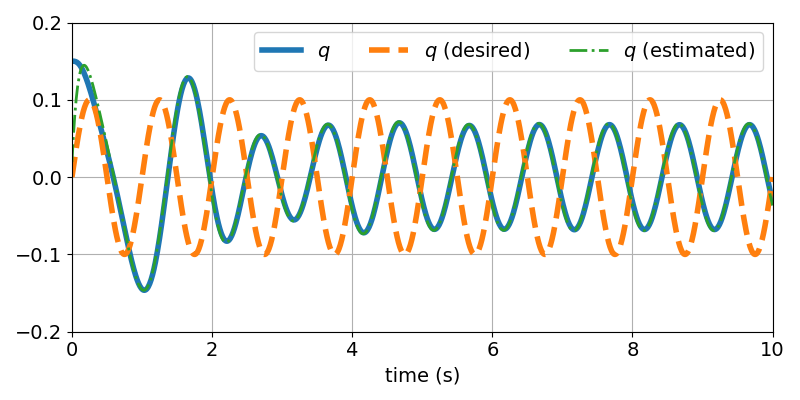

In [19]:
# Choose amplitude of oscillation
a = 0.1

# Choose period of oscillation
T = 1.
omega = 2 * np.pi / T

# # Choose frequency of oscillation
# omega = 1.
# T = 2 * np.pi / omega

# Show period and frequency of oscillation
print(f'omega = {omega:.3f} (T = {T:.3f})')

# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: a * np.sin(omega * t)

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.15, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.,
)

# Reset controller
controller.reset()

# Run simulator
simulator.display_meshcat = False
data = simulator.run(
    controller,
    max_time=10 * T,
)

# Show results
# show_results(data, q_e, v_e, tau_e)
show_results_q(data, q_e, v_e, tau_e)

Find the frequency, magnitude, and angle of the output.

In [20]:
# # Frequency
# t_peak_1 = 0. # <-- MEASURE FROM PLOT
# t_peak_2 = 0. # <-- MEASURE FROM PLOT
# T = t_peak_2 - t_peak_1
# omega = 2 * np.pi / T
# print(f'T = {T:6.2} seconds')

# Magnitude
a_input = a
a_output = 0.068 # <-- MEASURE FROM PLOT
mag = a_output / a_input
print(f'mag = {mag:6.2}')

# Angle
t_peak_1 = 8.25 # <-- MEASURE FROM PLOT
t_peak_2 = 8.67 # <-- MEASURE FROM PLOT
ang = - 2 * np.pi * ((t_peak_2 - t_peak_1) / T)
print(f'ang = {ang:6.2} radians')

mag =   0.68
ang =   -2.6 radians


Choose $T = 2$.

omega = 3.142 (T = 2.000)


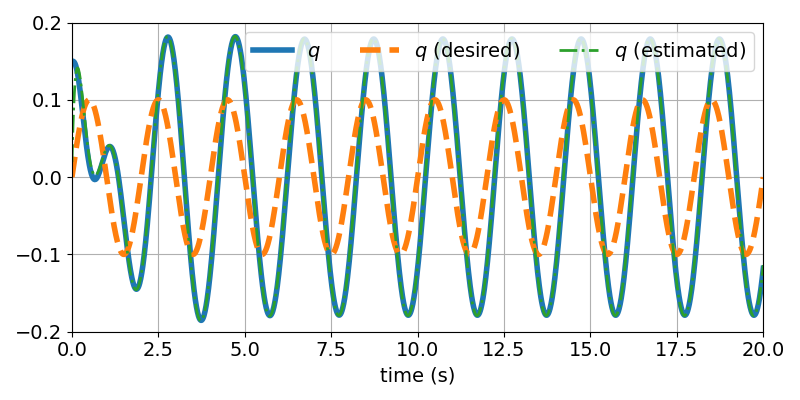

In [21]:
# Choose amplitude of oscillation
a = 0.1

# Choose period of oscillation
T = 2.
omega = 2 * np.pi / T

# # Choose frequency of oscillation
# omega = 1.
# T = 2 * np.pi / omega

# Show period and frequency of oscillation
print(f'omega = {omega:.3f} (T = {T:.3f})')

# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: a * np.sin(omega * t)

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.15, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.,
)

# Reset controller
controller.reset()

# Run simulator
simulator.display_meshcat = False
data = simulator.run(
    controller,
    max_time=10 * T,
)

# Show results
# show_results(data, q_e, v_e, tau_e)
show_results_q(data, q_e, v_e, tau_e)

Find the frequency, magnitude, and angle of the output.

In [23]:
# # Frequency
# t_peak_1 = 0. # <-- MEASURE FROM PLOT
# t_peak_2 = 0. # <-- MEASURE FROM PLOT
# T = t_peak_2 - t_peak_1
# omega = 2 * np.pi / T
# print(f'T = {T:6.2} seconds')

# Magnitude
a_input = a
a_output = 0.178 # <-- MEASURE FROM PLOT
mag = a_output / a_input
print(f'mag = {mag:6.2}')

# Angle
t_peak_1 = 16.5 # <-- MEASURE FROM PLOT
t_peak_2 = 16.7 # <-- MEASURE FROM PLOT
ang = - 2 * np.pi * ((t_peak_2 - t_peak_1) / T)
print(f'ang = {ang:6.2} radians')

mag =    1.8
ang =  -0.63 radians


Choose $T = 5$.

omega = 1.257 (T = 5.000)


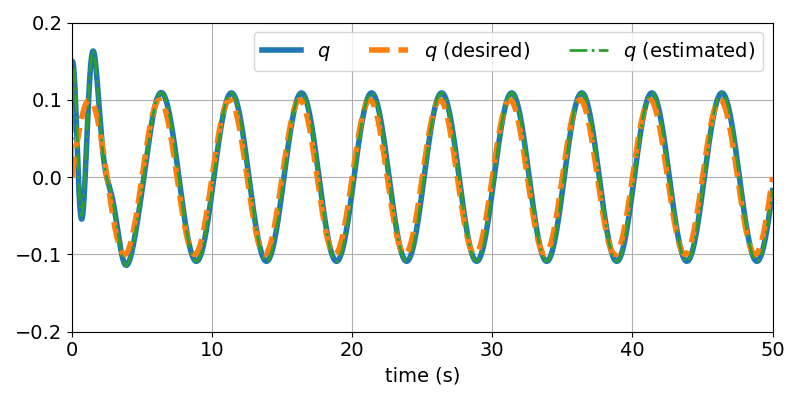

In [24]:
# Choose amplitude of oscillation
a = 0.1

# Choose period of oscillation
T = 5.
omega = 2 * np.pi / T

# # Choose frequency of oscillation
# omega = 1.
# T = 2 * np.pi / omega

# Show period and frequency of oscillation
print(f'omega = {omega:.3f} (T = {T:.3f})')

# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: a * np.sin(omega * t)

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.15, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.,
)

# Reset controller
controller.reset()

# Run simulator
simulator.display_meshcat = False
data = simulator.run(
    controller,
    max_time=10 * T,
)

# Show results
# show_results(data, q_e, v_e, tau_e)
show_results_q(data, q_e, v_e, tau_e)

Find the frequency, magnitude, and angle of the output.

In [25]:
# # Frequency
# t_peak_1 = 0. # <-- MEASURE FROM PLOT
# t_peak_2 = 0. # <-- MEASURE FROM PLOT
# T = t_peak_2 - t_peak_1
# omega = 2 * np.pi / T
# print(f'T = {T:6.2} seconds')

# Magnitude
a_input = a
a_output = 0.109 # <-- MEASURE FROM PLOT
mag = a_output / a_input
print(f'mag = {mag:6.2}')

# Angle
t_peak_1 = 41.25 # <-- MEASURE FROM PLOT
t_peak_2 = 41.38 # <-- MEASURE FROM PLOT
ang = - 2 * np.pi * ((t_peak_2 - t_peak_1) / T)
print(f'ang = {ang:6.2} radians')

mag =    1.1
ang =  -0.16 radians


## Analysis

#### Find the transfer function from $q_\text{des}$ to $q$

Define a matrix that picks the only element of $x_\text{des}$ that varies.

In [26]:
e_1 = np.array([[1.], [0.]])

show_matrix('e_1', e_1)

$$e_1 = \left[\begin{matrix}1\\0\end{matrix}\right]$$

Define closed-loop model.

In [27]:
Am = np.block([[A    , -B @ K           ],
               [L @ C, A - B @ K - L @ C]])

Bm = np.block([[B @ K @ e_1],
               [B @ K @ e_1]])

Cm = np.block([[e_1.T, np.zeros((1, A.shape[0]))]])

show_matrix('A_m', Am)
show_matrix('B_m', Bm)
show_matrix('C_m', Cm)

$$A_m = \left[\begin{matrix}0 & 1 & 0 & 0\\0 & 0 & -17 & -2\\13 & 0 & -13 & 1\\42 & 0 & -59 & -2\end{matrix}\right]$$

$$B_m = \left[\begin{matrix}0\\17\\0\\17\end{matrix}\right]$$

$$C_m = \left[\begin{matrix}1 & 0 & 0 & 0\end{matrix}\right]$$

Define the **transfer function**

$$H(s) = C_m (s - A_m)^{-1} B_m$$

where $s\in\mathbb{C}$ is a complex number.

First, do this symbolically.

In [28]:
# Create symbolic variable
s = sym.symbols('s')

# Convert A, B, C from numeric to symbolic
Am_sym = sym.nsimplify(sym.Matrix(Am), rational=True)
Bm_sym = sym.nsimplify(sym.Matrix(Bm), rational=True)
Cm_sym = sym.nsimplify(sym.Matrix(Cm), rational=True)

# Derive transfer function
H_sym = sym.simplify(Cm_sym @ (s * sym.eye(Am_sym.shape[0]) - Am_sym).inv() @ Bm_sym)[0, 0]

# Show result
show_transfer_function('H', H_sym)

$$H(s) = \frac{17}{s^{2} + 2 s + 17}$$

Then, do this numerically.

In [29]:
H = lambda s: (Cm @ linalg.inv(s * np.eye(Am.shape[0]) - Am) @ Bm).item()

Find the magnitude $|H(j\omega)|$ and the angle $\angle H(j\omega)$ of the complex number $H(j\omega)$ for different choices of frequency $\omega$ (radians / second).

Remember that any complex number $z\in\mathbb{C}$ can be written as

$$z = |z|e^{\angle z} = |z| \left( \cos(\angle z) + j \sin(\angle z) \right)$$

and that the period $T$ (in seconds) of a sinusoid with frequency $\omega$ (in radians / second) is

$$T = \dfrac{2\pi}{\omega}.$$

In [30]:
omega = (2 * np.pi) / 1
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega} (T = {2 * np.pi / omega:.3f})')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

omega = 6.283185307179586 (T = 1.000)
H(j omega) = -0.5762-0.3221j
mag = 0.6601
ang = -2.6318


In [31]:
omega = (2 * np.pi) / 2
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega} (T = {2 * np.pi / omega:.3f})')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

omega = 3.141592653589793 (T = 2.000)
H(j omega) = 1.3421-1.1826j
mag = 1.7888
ang = -0.7223


In [ ]:
omega = (2 * np.pi) / 5
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega} (T = {2 * np.pi / omega:.3f})')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

Visualize these results.

In [ ]:
# Choose amplitude of oscillation
a = 0.1

# Choose period of oscillation (CHANGE THIS TO SEE DIFFERENT EXAMPLES)
T = 1.
omega = 2 * np.pi / T

# # Choose frequency of oscillation
# omega = 1.
# T = 2 * np.pi / omega

# Show period and frequency of oscillation
print(f'omega = {omega:.3f} (T = {T:.3f})')

# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: a * np.sin(omega * t)

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.15, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.,
)

# Reset controller
controller.reset()

# Run simulator
simulator.display_meshcat = False
data = simulator.run(
    controller,
    max_time=10 * T,
)

# Predict results
omega = (2 * np.pi) / T
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega} (T = {2 * np.pi / omega:.3f})')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

# Show results
#
#  Could also do...
#
#    show_results(data, q_e, v_e, tau_e)
#
#  ...if you want to see everything and not just wheel angle.
#
show_results_q(
    data,
    q_e, v_e, tau_e,
    omega, a * np.absolute(H(1j * omega)), np.angle(H(1j * omega)),
    linewidth=4,
)

#### Show Bode Plot

Create Bode plot (i.e., plot magnitude and angle of $H(jw)$ as $w$ varies).

In [ ]:
omega = np.logspace(-2, 2, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax_mag.loglog(omega, mag, linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=14)
ax_mag.yaxis.set_minor_locator(MultipleLocator(1e-1))
ax_mag.set_yticklabels([], minor=True)
ax_mag.set_ylabel('magnitude', fontsize=16)
ax_ang.semilogx(omega, ang, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=14)
ax_ang.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_ang.set_yticklabels([], minor=True)
ax_ang.set_ylabel('angle (radians)', fontsize=16)
ax_ang.set_ylim([-np.pi, np.pi])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

Create Bode plot again, with magnitude in dB and angle in degrees.

In [ ]:
omega = np.logspace(-2, 2, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

mag_in_dB = 20. * np.log10(mag)
ang_in_deg = np.rad2deg(ang)

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax_mag.semilogx(omega, mag_in_dB, linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=12)
ax_mag.yaxis.set_major_locator(MultipleLocator(20))
ax_mag.set_ylabel('magnitude (dB)', fontsize=16)
ax_ang.semilogx(omega, ang_in_deg, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=12)
ax_ang.yaxis.set_major_locator(MultipleLocator(45))
ax_ang.set_ylabel('angle (degrees)', fontsize=16)
ax_ang.set_ylim([-180, 180])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

Create Bode plot yet again, showing the $-3\;\text{dB}$ line to compute bandwidth.

In [ ]:
omega = np.logspace(-2, 2, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

mag_in_dB = 20. * np.log10(mag)
ang_in_deg = np.rad2deg(ang)

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax_mag.semilogx(omega, mag_in_dB, linewidth=2)
ax_mag.semilogx(omega, -3. * np.ones_like(omega), '--', linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=12)
ax_mag.yaxis.set_major_locator(MultipleLocator(20))
ax_mag.set_ylabel('magnitude (dB)', fontsize=16)
ax_ang.semilogx(omega, ang_in_deg, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=12)
ax_ang.yaxis.set_major_locator(MultipleLocator(45))
ax_ang.set_ylabel('angle (degrees)', fontsize=16)
ax_ang.set_ylim([-180, 180])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()